# Проект 4

# Приложение Procrastinate Pro+. Анализ бизнес-показателей.

#### Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

### Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

### Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

Импортируем данные - начнем с визитов.

In [3]:
visits = pd.read_csv('/Users/sergejnitkin/5_project_BAproject_data/visits_info_short.csv')
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Переименуем колонки для удобства работы

In [4]:
visits.columns

Index(['User Id', 'Region', 'Device', 'Channel', 'Session Start',
       'Session End'],
      dtype='object')

In [5]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Приведем колонки к формату datetime

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

Проверим на дубликаты.

In [7]:
visits.duplicated().sum()

0

Импортируем следующую таблицу.

In [8]:
orders = pd.read_csv('/Users/sergejnitkin/5_project_BAproject_data/orders_info_short.csv')
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Также для удобства переименуем колонки.

In [9]:
orders.columns = ['user_id', 'event_dt', 'revenue']
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

Приведем к datetime

In [10]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

Проверим на дубликаты

In [11]:
orders.duplicated().sum()

0

Далее импортируем следующую таблицу

In [12]:
ad_costs = pd.read_csv('/Users/sergejnitkin/5_project_BAproject_data/costs_info_short.csv')
ad_costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Также переименуем колонки и приведем к datetime, затем проверим на дубликаты

In [13]:
ad_costs.columns = ['dt', 'channel', 'costs']
ad_costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [14]:
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

In [15]:
ad_costs.duplicated().sum()

0

### Создадим профили пользователей

#### Введем функцию для построения профилей

In [16]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

## Исследовательский анализ данных

Передадим функции наши датасеты и построим профили.

In [17]:
events = None #поскольку датасета с маркировкой ивентов у нас нет
profiles = get_profiles(visits, orders, events, ad_costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


#### Определим минимальную и максимальную дату привлечения

In [18]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()

print('Минимальная дата привлечения: {}'.format(min_date))
print('Максимальная дата привлечения: {}'.format(max_date))

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


#### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [19]:
users_by_country = profiles.pivot_table(index='region', columns='payer', values='user_id', aggfunc='nunique')
users_by_country.columns = ['non_payers', 'payers']
users_by_country['payers_to_users_ratio'] = (users_by_country['payers'] / 
                                    (users_by_country['non_payers'] + users_by_country['payers']))

users_by_country = users_by_country.sort_values(by='payers', ascending=False)
users_by_country

,non_payers,payers,payers_to_users_ratio
region,,,
United States,93100,6902,0.069019
UK,16875,700,0.039829
France,16787,663,0.037994
Germany,14365,616,0.041119


Итак, больше всего пользователей МК(маркетинговая кампания) привлекла в США, платящих пользователей там тоже больше всего, что закономерно, но также стоит отметить, что в США и самая высокая доля платящих - она составляет почти 7%, в то время как у второй страны всего 4% посетителей конвертируются в покупателей.

#### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [20]:
users_by_device = profiles.pivot_table(index='device', columns='payer', values='user_id', aggfunc='nunique')
users_by_device.columns = ['non_payers', 'payers']
users_by_device['payers_to_users_ratio'] = (users_by_device['payers'] / 
                                    (users_by_device['non_payers'] + users_by_device['payers']))

users_by_device = users_by_device.sort_values(by='payers', ascending=False)
users_by_device

,non_payers,payers,payers_to_users_ratio
device,,,
iPhone,51097,3382,0.062079
Android,32982,2050,0.058518
Mac,28130,1912,0.063644
PC,28918,1537,0.050468


Здесь стоит заметить, что больше всего платящих пользователей заходит с Iphone и вообще конвертация в покупателей у пользователей Apple не много выше, чем у остальных - чуть больше 6%, в то время как PC и Android - 5% и 5.8% соответственно.

#### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [21]:
users_by_channel = profiles.pivot_table(index='channel', columns='payer', values='user_id', aggfunc='nunique')
users_by_channel.columns = ['non_payers', 'payers']
users_by_channel['payers_to_users_ratio'] = (users_by_channel['payers'] / 
                                    (users_by_channel['non_payers'] + users_by_channel['payers']))

users_by_channel = users_by_channel.sort_values(by='payers', ascending=False)
users_by_channel

,non_payers,payers,payers_to_users_ratio
channel,,,
FaceBoom,25587,3557,0.122049
TipTop,17683,1878,0.096007
organic,55279,1160,0.020553
WahooNetBanner,8100,453,0.052964
AdNonSense,3440,440,0.113402
RocketSuperAds,4096,352,0.079137
LeapBob,8291,262,0.030633
OppleCreativeMedia,8372,233,0.027077
lambdaMediaAds,1924,225,0.104700


Больше всего пользователей приходит из 3-х каналов - это FaceBoom, TipTop и органический. Что же касается конвертации в покупателей, то тут можно выделить следующие каналы: FaceBoom, AdNonSense и lambdaMediaAds - тут в покупателей конвертируется более 10% трафика.

## Маркетинг

####  Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируйте изменения метрик во времени.

In [22]:
print('Сумма расходов на маркетинг: {}'.format(profiles['acquisition_cost'].sum().astype('int')))

Сумма расходов на маркетинг: 105497


In [23]:
ad_costs_by_channel = profiles.groupby('channel').agg({'acquisition_cost': 'sum'})
ad_costs_by_channel

,acquisition_cost
channel,
AdNonSense,3911.25
FaceBoom,32445.60
LeapBob,1797.60
MediaTornado,954.48
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
TipTop,54751.30
WahooNetBanner,5151.00
YRabbit,944.22


Тут стоит выделить 2 источника трафика с самыми большими тратами- это TipTop, который значительно опережает второе место FaceBoom. На эти два источника приходится почти 83% всех расходов на привлечение.

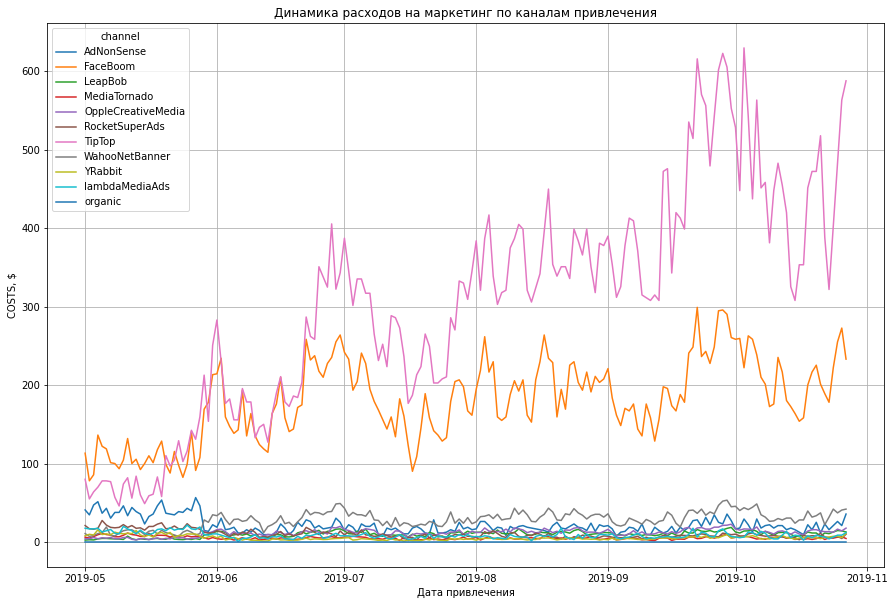

In [24]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(15, 10))
plt.ylabel('COSTS, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика расходов на маркетинг по каналам привлечения')
plt.show()

Из графика следует, что расходы на источники FaceBoom и TipTop в июне значительно выросли до 200уе, и если FaceBoom остался на этом уровне примерно, то расходы на TipTop продолжили рост уже в июне и в октябре состаляли более 600уе. В то время как затраты на остальные каналы не превышали 50уе на протяжении всего периода. 

#### Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

In [47]:
print('Средний CAC для всего проекта: {}'
      .format(profiles[profiles['channel'] != 'organic']['acquisition_cost'].mean()))
# для корректного расчета мы исключили органических пользователей

Средний CAC для всего проекта: 1.127481323942928


In [26]:
profiles.groupby('channel').agg({'acquisition_cost': 'mean'})

,acquisition_cost
channel,
AdNonSense,1.008054
FaceBoom,1.113286
LeapBob,0.210172
MediaTornado,0.218717
OppleCreativeMedia,0.250000
RocketSuperAds,0.412095
TipTop,2.799003
WahooNetBanner,0.602245
YRabbit,0.218975


Средний САС равен 1.13уе, в то время как самый высокий САС у TipTop - почти 2.8уе, у источников FaceBoom и AdNonSense чуть более 1уе, остальные источники имеют САС значительно ниже.

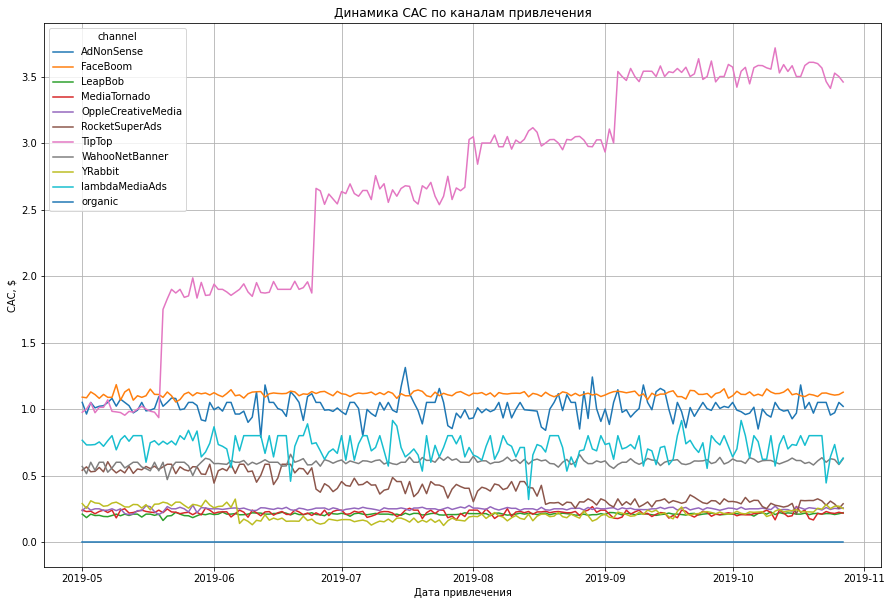

In [27]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 10))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика CAC по каналам привлечения')
plt.show()

На графике выше мы видим динамику САС по источникам, тут стоит отметить TipTop САС которого постоянно растет на протяжении всего периода наблюдения, в то время как стоимость остальных САС стабильна.

## Оценим окупаемость рекламы

Для анализа окупаемости рекламы проанализируем LTV, ROI и CAC.

Введем функции get_ltv(), plot_ltv_roi() и filter_data().

In [28]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [29]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [30]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


###  Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [49]:
horizon_days = 14
observation_date = datetime(2019, 11, 1).date()
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles[profiles['channel'] != 'organic'], 
                                                      orders, 
                                                      observation_date, 
                                                      horizon_days, 
                                                      dimensions=[], 
                                                      ignore_horizon=False) 

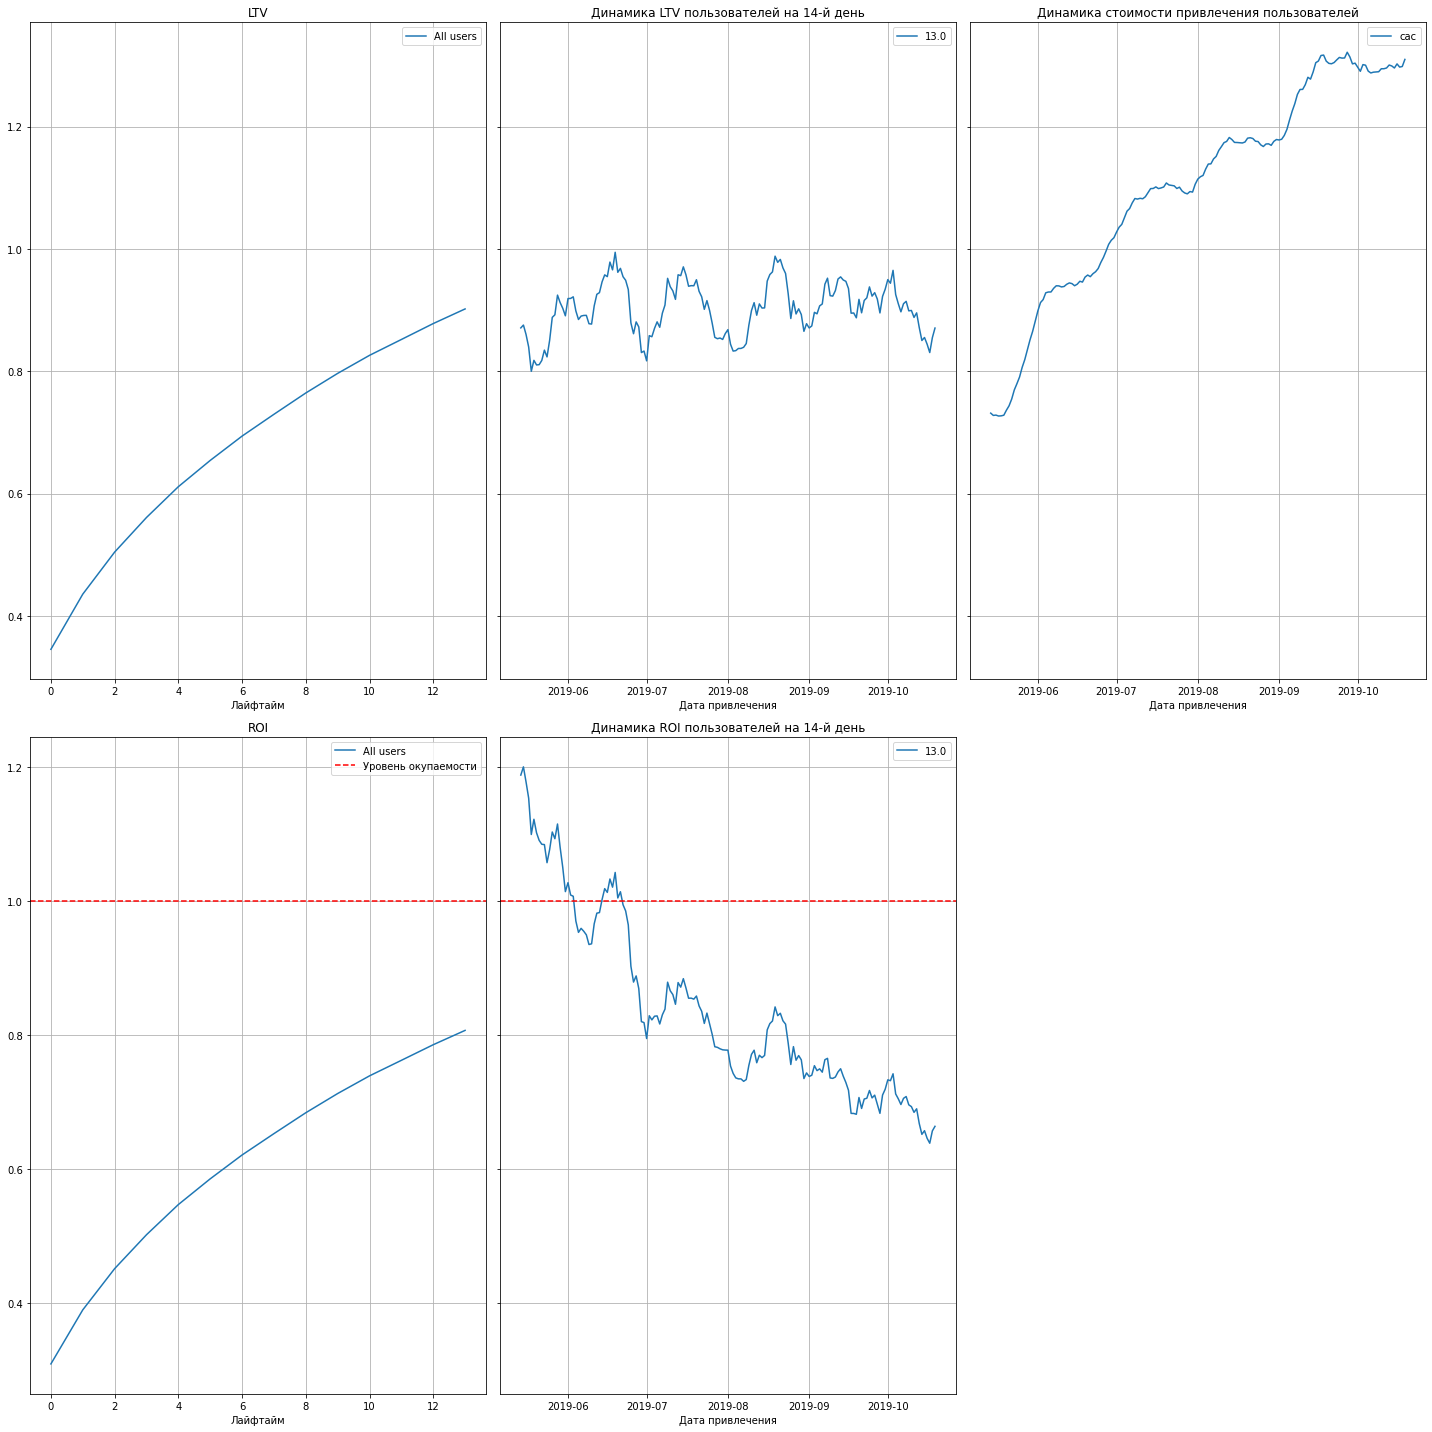

In [50]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Что мы можем видеть на графиках: LTV для пользователей стабилен от месяца к месяцу, он выше для пользователей, привлеченных середине месяца. Также мы можем наблюдать стремительное увеличение САС, начиная посетителей, привлеченных с середины мая, и соответсвенно, в связи с ростом САС, уже для посетителей привлеченных, начиная с 3 декады июня, ROI < 1.

### Проанализирем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [33]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, 
                                                      orders, 
                                                      observation_date, 
                                                      horizon_days, 
                                                      dimensions=['channel'], 
                                                      ignore_horizon=False) 

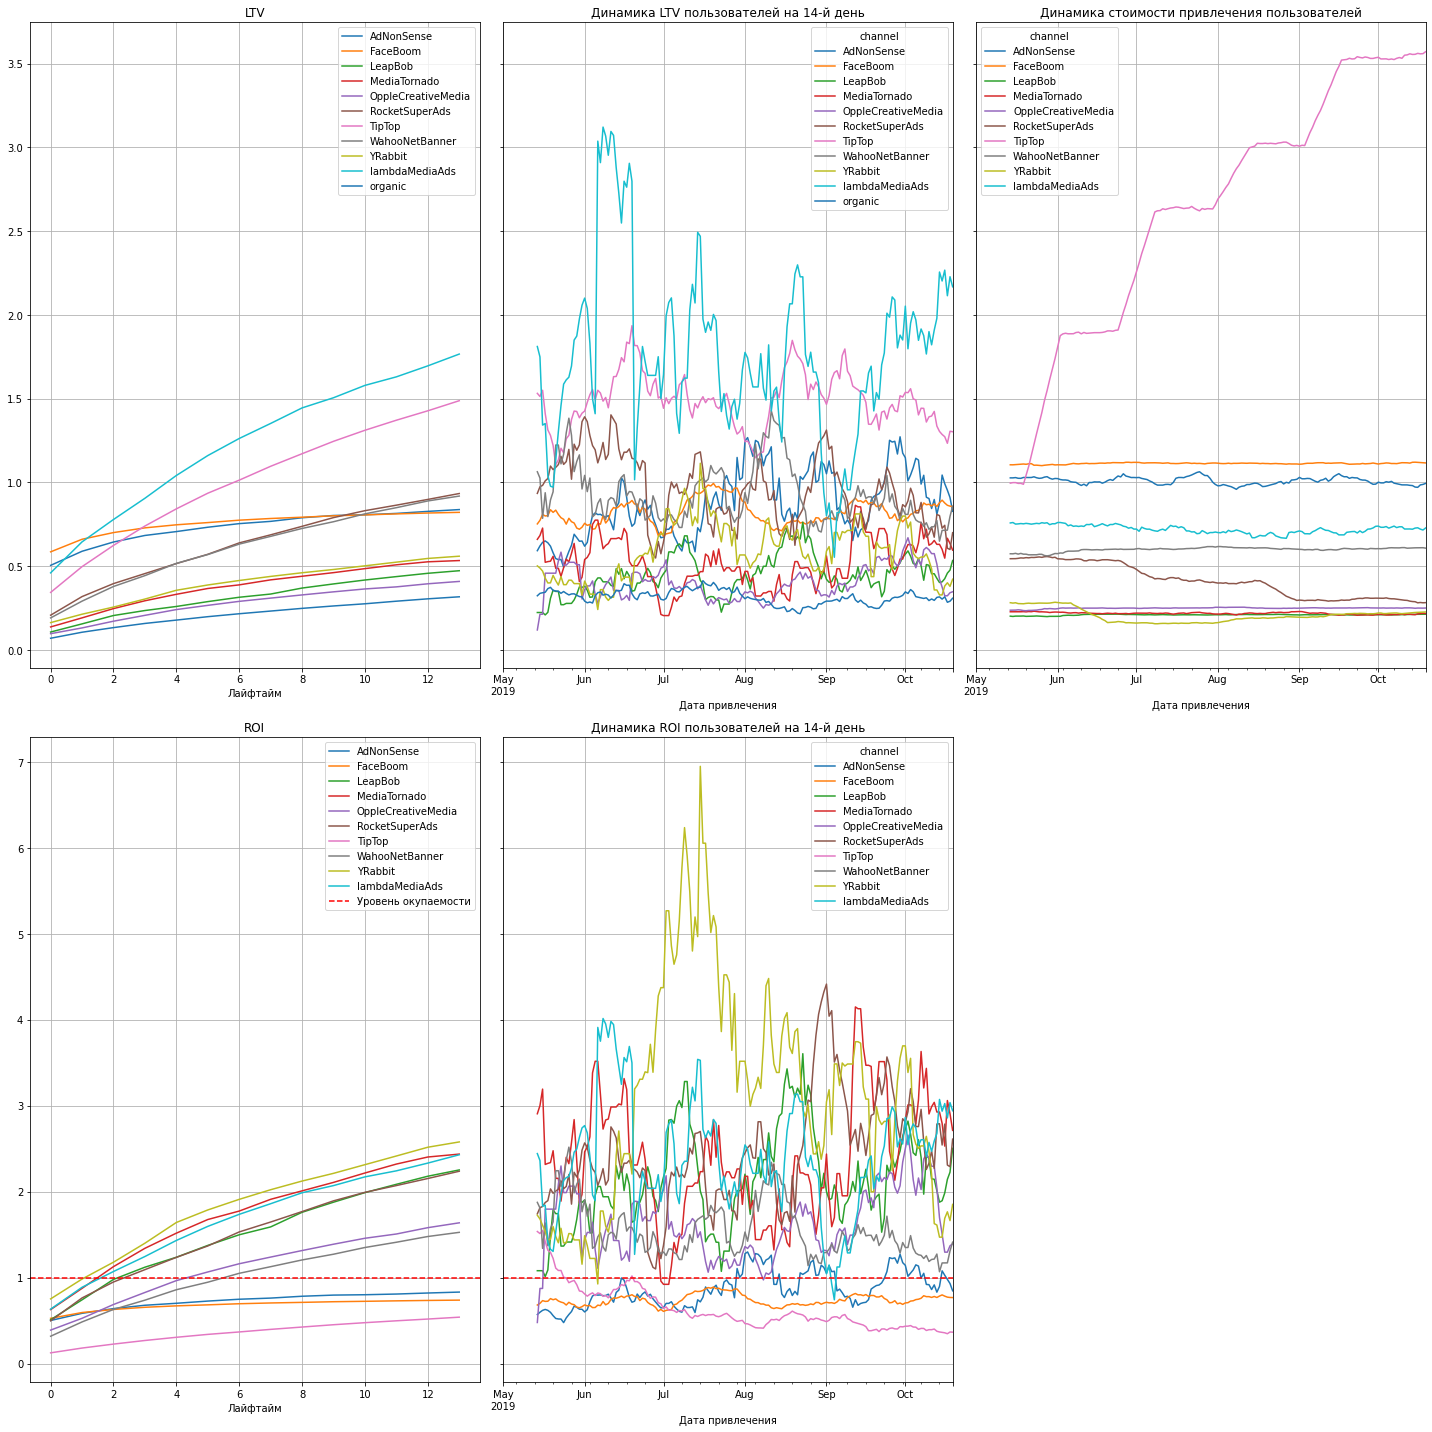

In [34]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Самый высокий LTV у lambdaMediaAds и TipTop, но ввиду высокой и постоянно растущей стоиимости привлечения TipTop уже в конце мая ROI опустился ниже единицы, также ниже окупаемости следующие рекламные каналы: AdNonSense и Faceboom. Стоит также отметить высокие показатели ROI для пользователей, привлеченных в июле через YRabbit.

### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [35]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, 
                                                      orders, 
                                                      observation_date, 
                                                      horizon_days, 
                                                      dimensions=['region'], 
                                                      ignore_horizon=False)

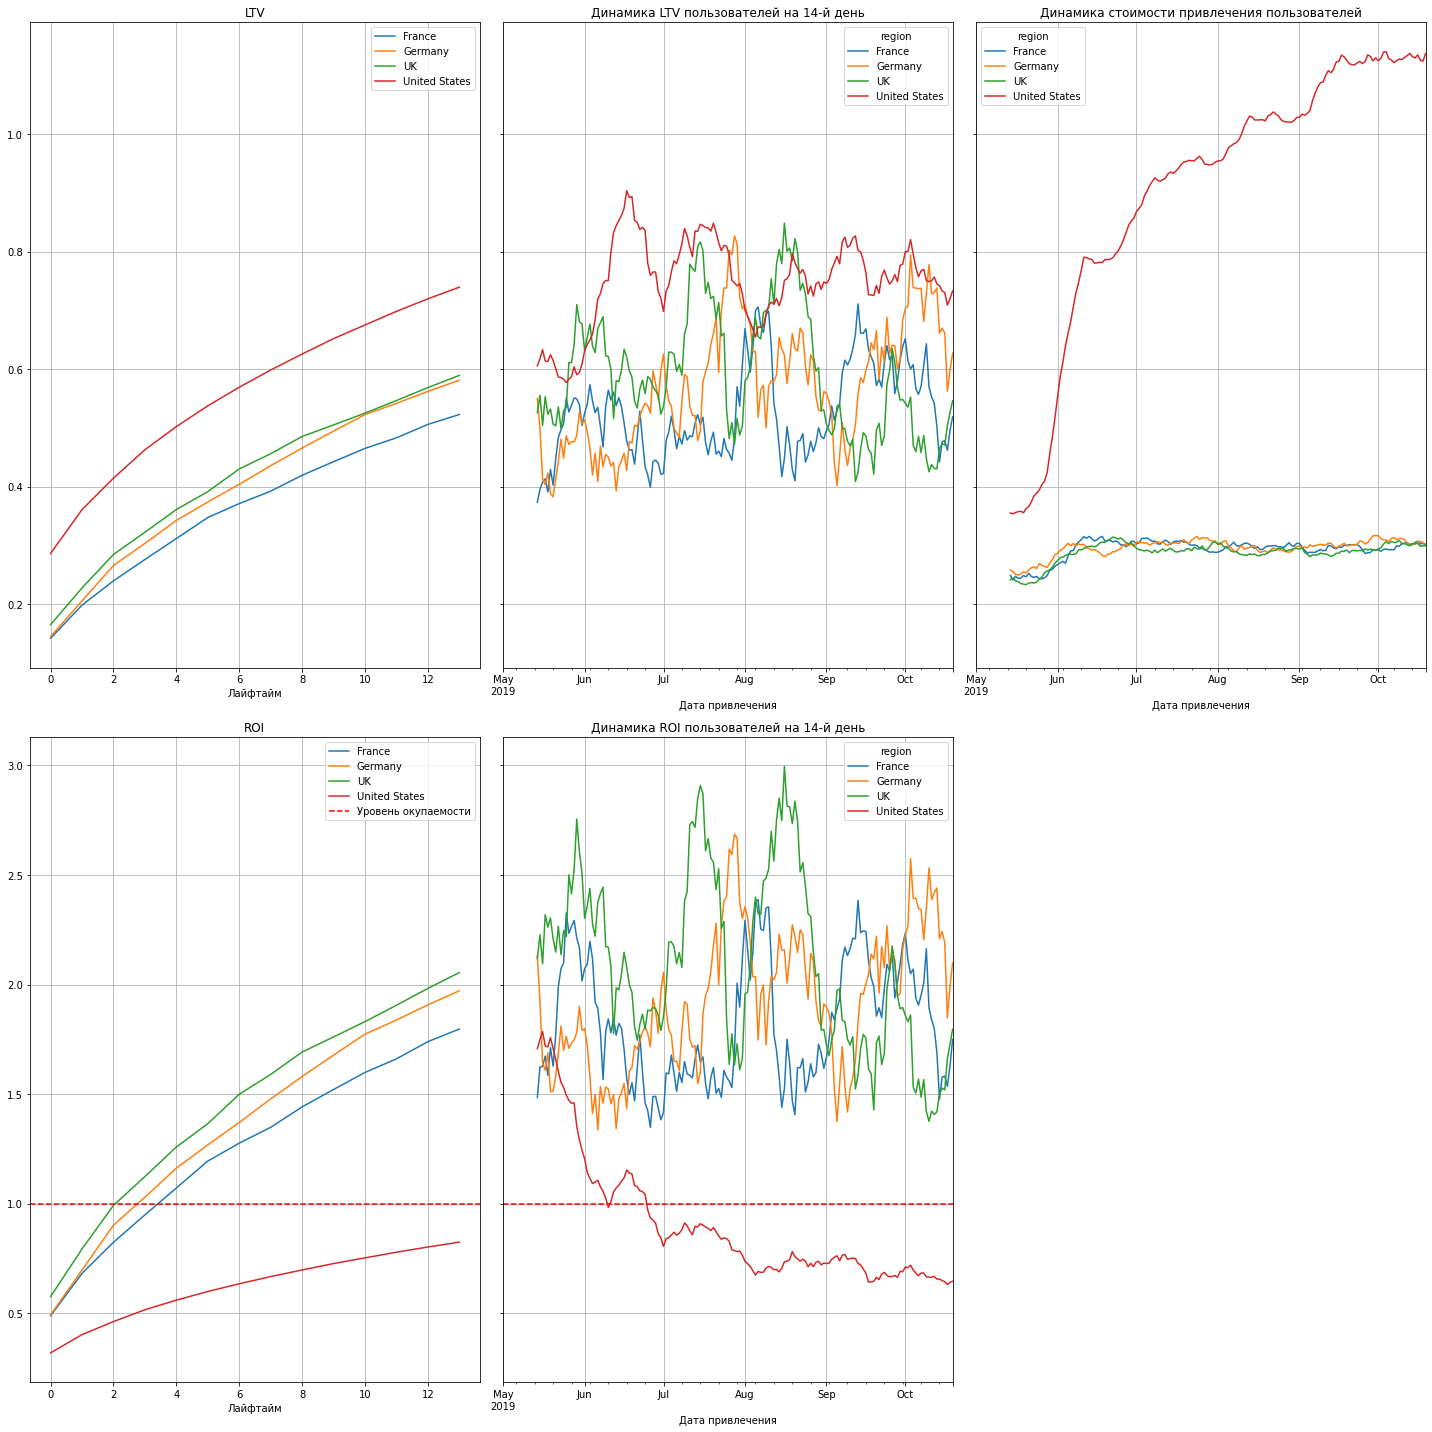

In [36]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Тут стоит отметить, что самый высокий LTV для пользователей из США, но ввиду высокой стоимости привлечения, США - единственная страна для пользователей которой ROI < 1. Привлечение пользователей из других стран окупается уже на 2-4 день лайфтайма.

### Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

Для этого введем функции get_retention(), get_conversion(), plot_retention(), plot_conversion().

In [37]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


In [38]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [39]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 15))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [40]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Итак посмотрим на удержание и конверсию пользователей.

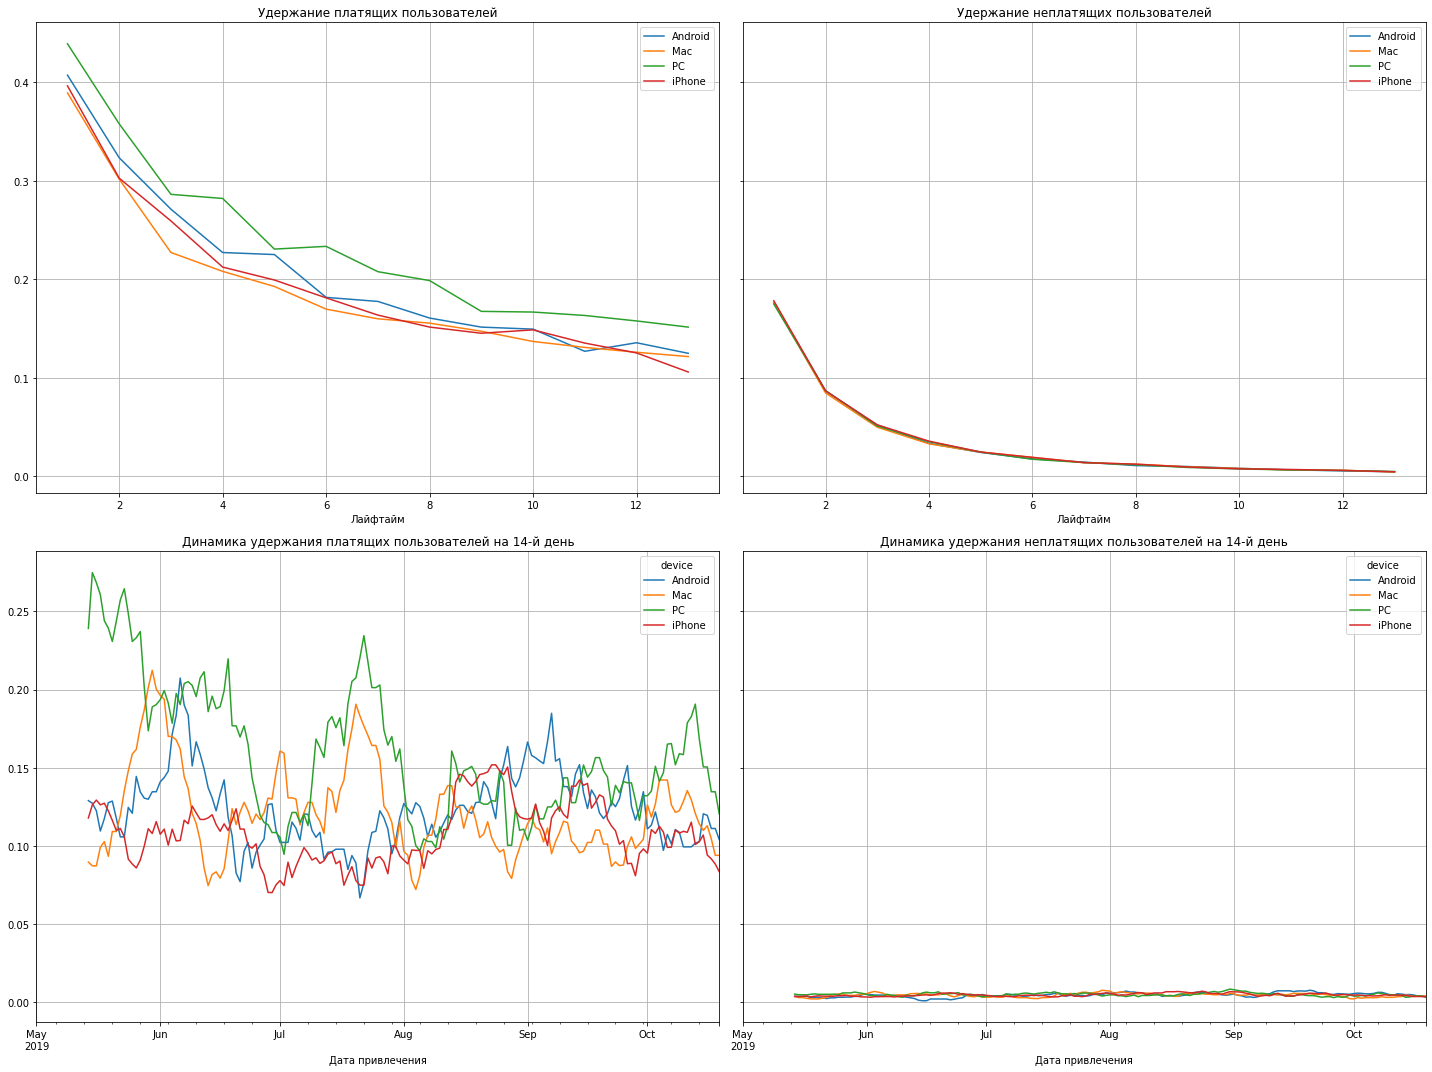

In [41]:
retention_raw, retention, retention_history = get_retention(profiles,
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['device'],
                                                            ignore_horizon=False)

plot_retention(retention, retention_history, horizon_days, window=14)

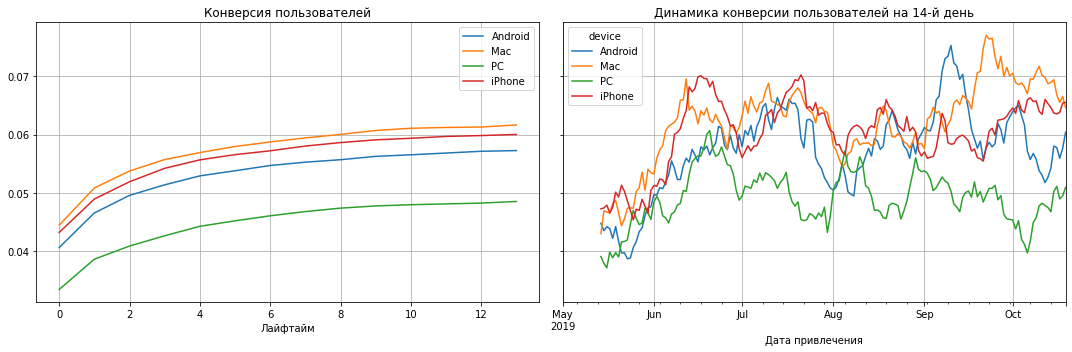

In [42]:
conversion_raw, conversion, conversion_history = get_conversion(
                                                                profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                                dimensions=['device'],
                                                                ignore_horizon=False,
                                                                )
plot_conversion(conversion, conversion_history, horizon_days, window=14)

Из графиков можно наблюдать, что пользователи Мак и Айфон охотнее конвертируются в покупателей - так 6% пользователей айфонов и 6.2% пользователей Мак конвертируются в покупателей, в то время как самый низкий процент конвертации (4.9%) у пользователей РС. Но плтящие пользователи РС охотнее удерживаются, в то время как пользователи айфонов обладают самым низким коэффициентом удержания - только 11% платящих пользователей айфон проживают 14 дневный лайфтайм. Для неплатящих пользователей картина удержания одинакова для всех устройств. Что касается динамики конверисии, то тут стоит заметить высокую конверсию пользователей Мак во второй половине сентября, в то время как в первой половине самая высокая конверсия была у Андройд устройств, еще стоило бы обратить внимание на провал конверсии пользователей РС в начале октября.

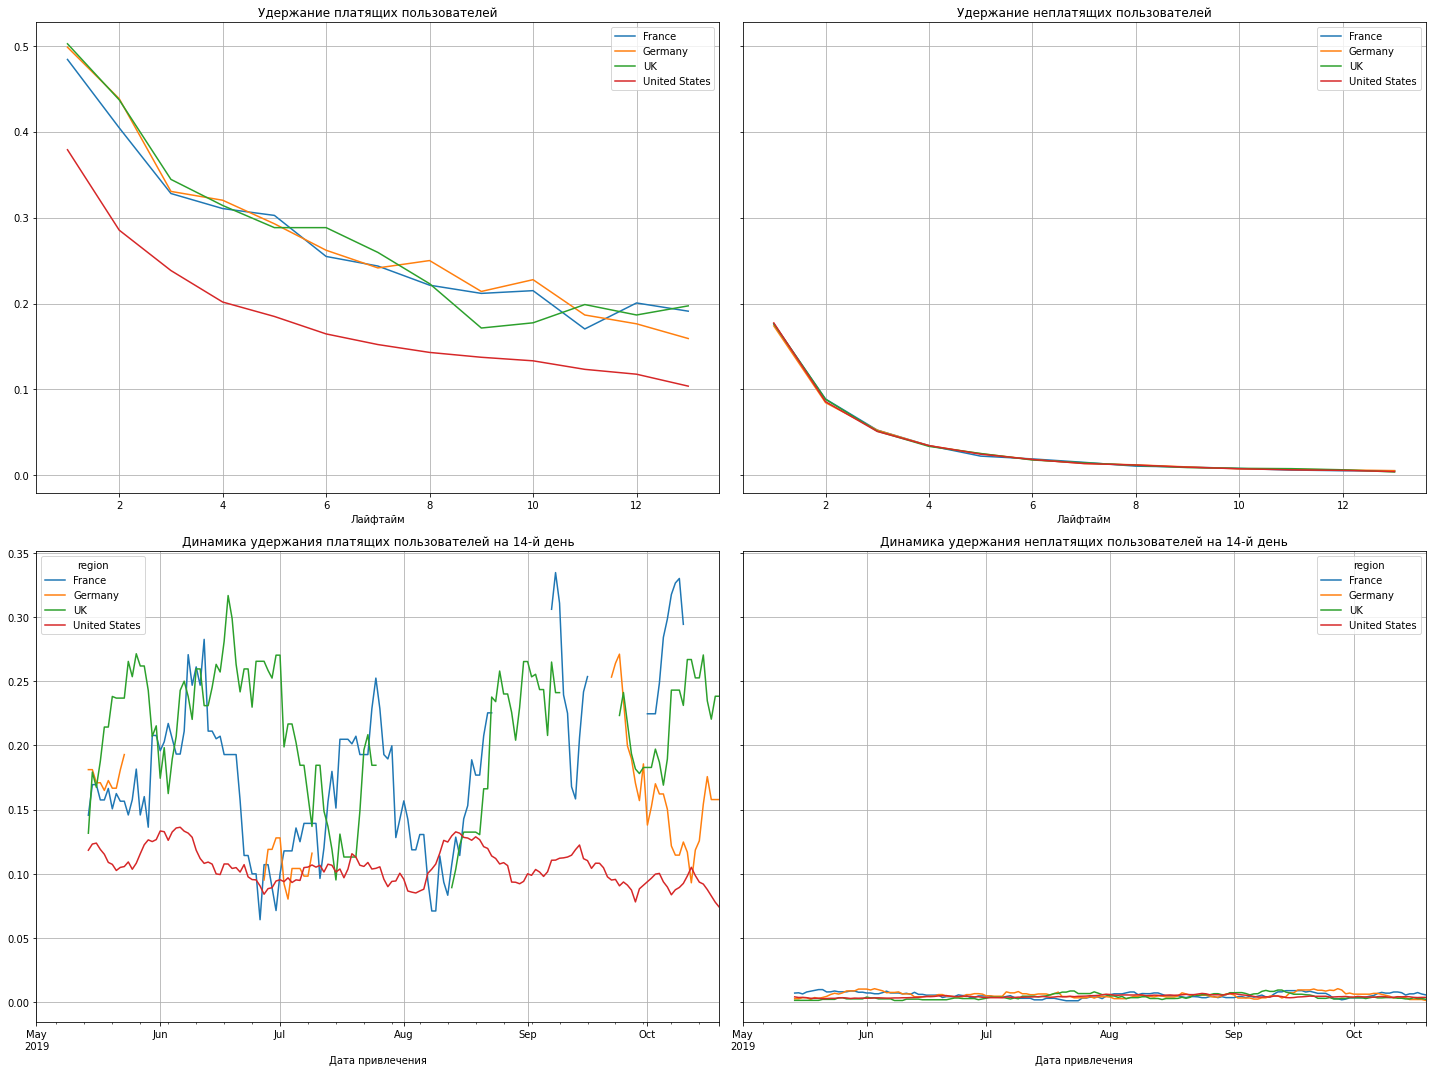

In [43]:
retention_raw, retention, retention_history = get_retention(profiles,
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['region'],
                                                            ignore_horizon=False)

plot_retention(retention, retention_history, horizon_days, window=14)

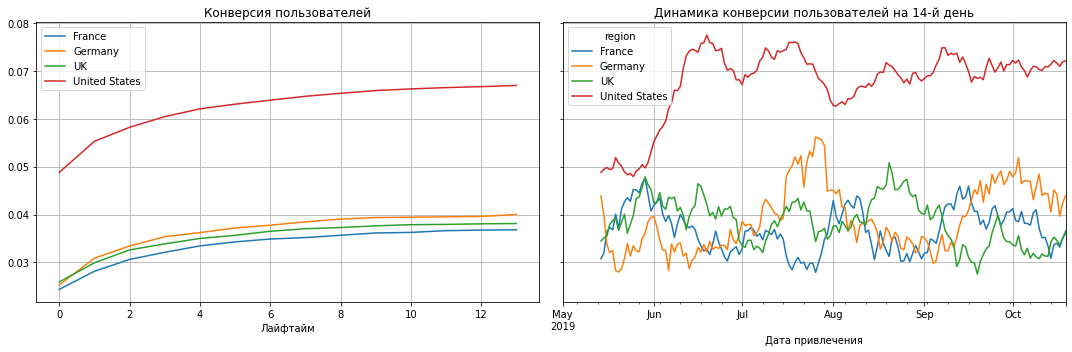

In [44]:
conversion_raw, conversion, conversion_history = get_conversion(
                                                                profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                                dimensions=['region'],
                                                                ignore_horizon=False,
                                                                )
plot_conversion(conversion, conversion_history, horizon_days, window=14)

Что здесь сразу бросается в глаза, так это конверсия в США почти 7% пользователей конвертируются в покупателей, что на 3 и более п.п. выше чем в остальных странах, в то время как в США самый низкий коэффициент удержания - только 10% пользователей проживает 14 дневный лайфтайм, в то время как для Франции и Британии - это почти 20%. что касается динамики конверсии, то в США она сильно выросла в июне, в Германии высокие показатели были во второй половине июля. Для Британии и Франции колебания носят скорее сезонный характер, причем сезонные колебания в Германии обратно пропорциональны Франции и Британии.

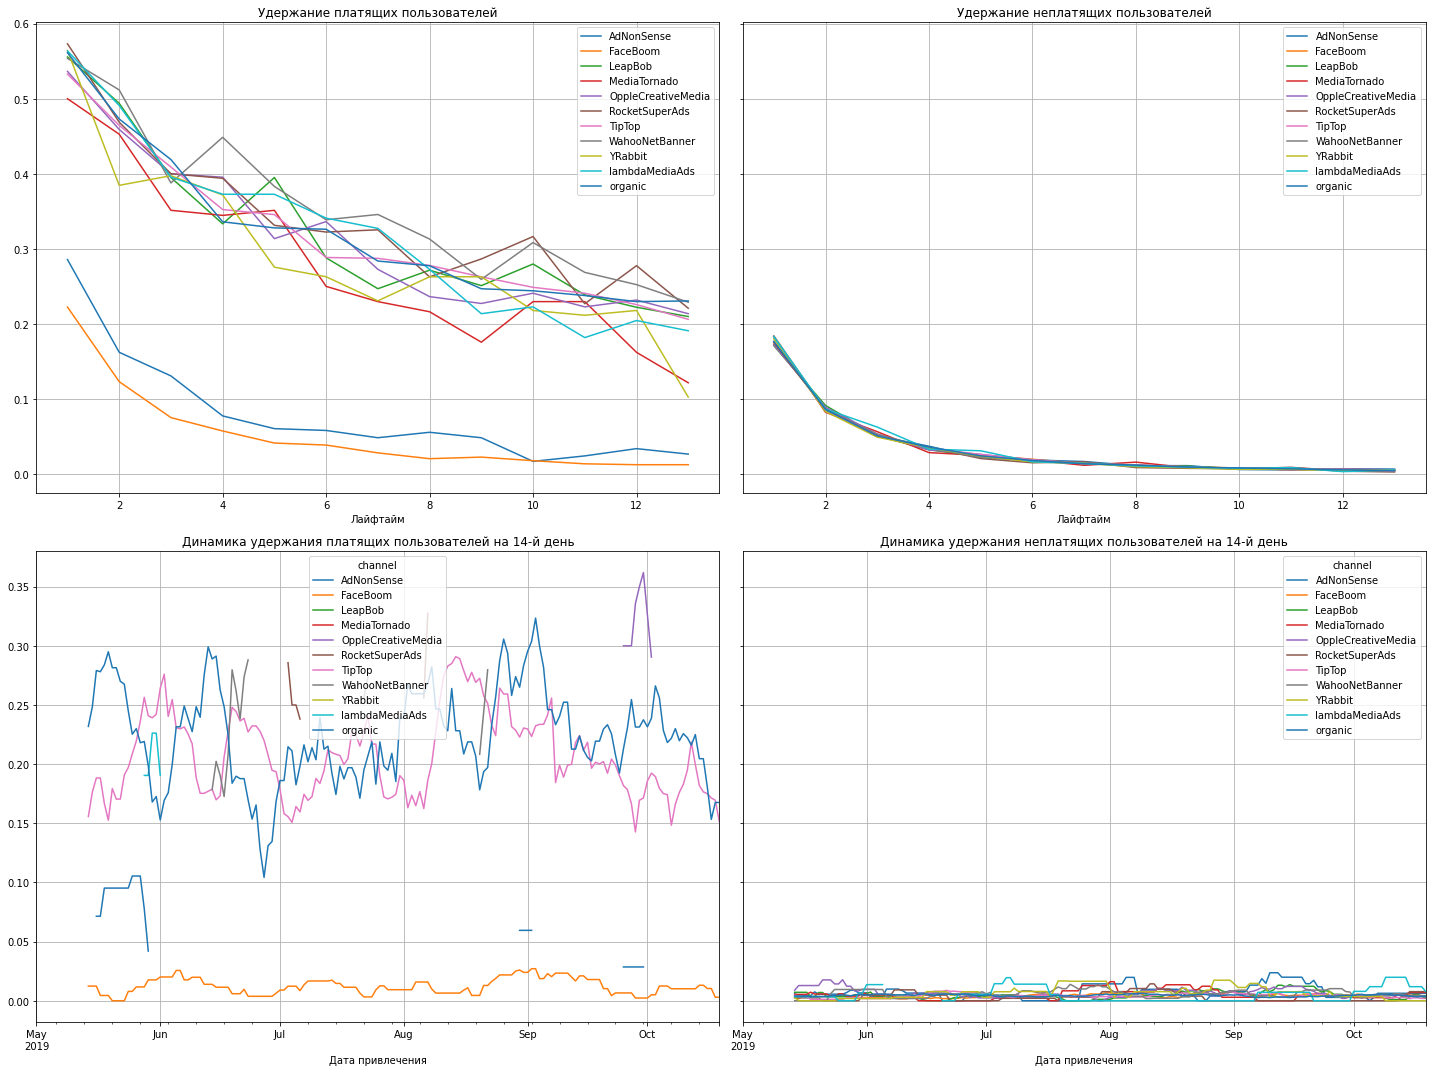

cohort_size    0         1         2         3  \
payer channel                                                              
False AdNonSense                 3289  1.0  0.176345  0.087565  0.051079   
      FaceBoom                  24182  1.0  0.172980  0.087214  0.050782   
      LeapBob                    7860  1.0  0.171120  0.091349  0.051272   
      MediaTornado               4019  1.0  0.183130  0.082359  0.056482   
      OppleCreativeMedia         7919  1.0  0.171991  0.089026  0.053416   
      RocketSuperAds             3916  1.0  0.175179  0.085802  0.051328   
      TipTop                    16713  1.0  0.181715  0.084605  0.050859   
      WahooNetBanner             7654  1.0  0.184217  0.085446  0.053044   
      YRabbit                    3946  1.0  0.180182  0.083376  0.049164   
      lambdaMediaAds             1836  1.0  0.183007  0.086601  0.062636   
      organic                   52866  1.0  0.176711  0.085991  0.050921   
True  AdNonSense                  413  1.0  0.285714  0.162228  0.130751   
      FaceBoom                   3362  1.0  0.222487  0.123141  0.075253   
      LeapBob                     243  1.0  0.555556  0.493827  0.395062   
      MediaTornado                148  1.0  0.500000  0.452703  0.351351   
      OppleCreativeMedia          220  1.0  0.536364  0.459091  0.400000   
      RocketSuperAds              335  1.0  0.573134  0.468657  0.400000   
      TipTop                     1785  1.0  0.532773  0.464426  0.408964   
      WahooNetBanner              428  1.0  0.553738  0.511682  0.387850   
      YRabbit                     156  1.0  0.564103  0.384615  0.397436   
      lambdaMediaAds              220  1.0  0.563636  0.490909  0.395455   
      organic                    1110  1.0  0.561261  0.472973  0.418919   

                                 4         5         6         7         8  \
payer channel                                                                
False AdNonSense          0.037093  0.021587  0.018851  0.016722  0.011250   
      FaceBoom            0.032710  0.025267  0.019767  0.013605  0.011910   
      LeapBob             0.032443  0.023155  0.018830  0.014504  0.010941   
      MediaTornado        0.028614  0.024882  0.018661  0.011694  0.015924   
      OppleCreativeMedia  0.032201  0.026266  0.019194  0.014522  0.011870   
      RocketSuperAds      0.035495  0.020684  0.015066  0.016343  0.008682   
      TipTop              0.034943  0.026028  0.018848  0.013941  0.012086   
      WahooNetBanner      0.034492  0.022211  0.017507  0.015025  0.011759   
      YRabbit             0.035226  0.023822  0.016219  0.014192  0.009883   
      lambdaMediaAds      0.033224  0.031046  0.016340  0.014161  0.010893   
      organic             0.036016  0.024231  0.018121  0.013695  0.011955   
True  AdNonSense          0.077482  0.060533  0.058111  0.048426  0.055690   
      FaceBoom            0.057406  0.041344  0.038667  0.028257  0.020523   
      LeapBob             0.333333  0.395062  0.288066  0.246914  0.271605   
      MediaTornado        0.344595  0.351351  0.250000  0.229730  0.216216   
      OppleCreativeMedia  0.395455  0.313636  0.336364  0.272727  0.236364   
      RocketSuperAds      0.394030  0.331343  0.322388  0.325373  0.262687   
      TipTop              0.352381  0.345658  0.288515  0.287395  0.277871   
      WahooNetBanner      0.448598  0.383178  0.338785  0.345794  0.313084   
      YRabbit             0.371795  0.275641  0.262821  0.230769  0.262821   
      lambdaMediaAds      0.372727  0.372727  0.340909  0.327273  0.272727   
      organic             0.336036  0.327928  0.326126  0.283784  0.277477   

                                 9        10        11        12        13  
payer channel                                                               
False AdNonSense          0.011250  0.006081  0.005473  0.006993  0.006689  
      FaceBoom            0.010007  0.008064  0.005500  0.006616  0.004342  
      LeapBob       

In [45]:
retention_raw, retention, retention_history = get_retention(profiles,
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['channel'],
                                                            ignore_horizon=False)

plot_retention(retention, retention_history, horizon_days, window=14)

retention

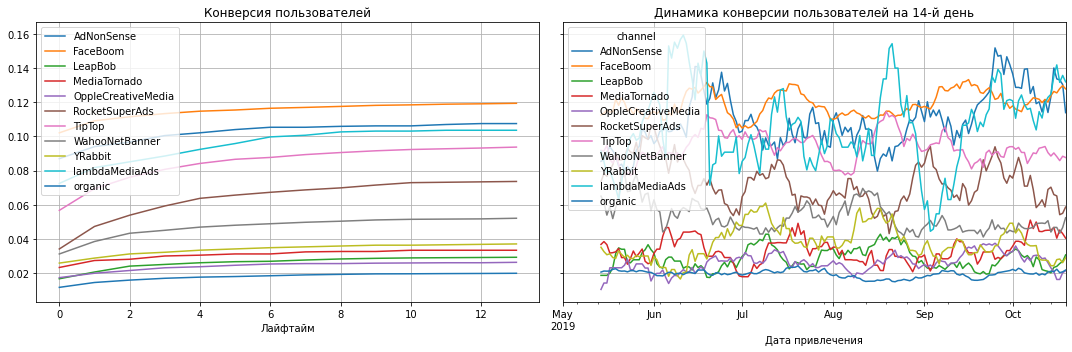

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
AdNonSense,3702,0.086980,0.094003,0.096704,0.100486,0.102107,0.103998,0.105348,0.105348,0.105889,0.106159,0.106159,0.106969,0.107509,0.107509
FaceBoom,27544,0.102091,0.109134,0.111494,0.113346,0.114762,0.115452,0.116468,0.116976,0.117557,0.118175,0.118465,0.118864,0.119082,0.119373
LeapBob,8103,0.016660,0.020610,0.024065,0.025052,0.026040,0.026657,0.026904,0.027644,0.028261,0.028631,0.028878,0.029002,0.029125,0.029248
MediaTornado,4167,0.023278,0.027358,0.028078,0.029998,0.030478,0.031198,0.031198,0.032397,0.032637,0.032637,0.033357,0.033357,0.033357,0.033357
OppleCreativeMedia,8139,0.017324,0.019904,0.021501,0.023099,0.023713,0.024573,0.025310,0.025556,0.025556,0.025802,0.025925,0.026047,0.026047,0.026293
RocketSuperAds,4251,0.034110,0.047283,0.053870,0.059280,0.063750,0.065632,0.067278,0.068690,0.069866,0.071513,0.072924,0.073159,0.073394,0.073630
TipTop,18498,0.056709,0.069413,0.076062,0.080711,0.084171,0.086604,0.087685,0.089361,0.090550,0.091577,0.092334,0.092767,0.093199,0.093740
WahooNetBanner,8082,0.031180,0.038481,0.043306,0.045038,0.046894,0.048008,0.048874,0.049740,0.050359,0.051101,0.051472,0.051596,0.051720,0.052091
YRabbit,4102,0.025841,0.028766,0.031204,0.032179,0.033398,0.034130,0.034861,0.035349,0.035836,0.036324,0.036324,0.036568,0.036811,0.037055


In [46]:
conversion_raw, conversion, conversion_history = get_conversion(
                                                                profiles,
                                                                orders,
                                                                observation_date,
                                                                horizon_days,
                                                                dimensions=['channel'],
                                                                ignore_horizon=False,
                                                                )
plot_conversion(conversion, conversion_history, horizon_days, window=14)
conversion

Что касается каналов привлечения, то каналы с самой высокой конверсией - это Фейсбум и Эднонсенс, в то же время это каналы с самым низким удержанием. Тут может быть стоило бы добавить акций, направленных на удержание пользователей, а как следствие повторных покупок. Что же касется органических пользователей, то тут традиционно высокое удержание, но низкая конвертация, тут следовало бы добавить акций, побуждающих к покупке. Что же касается не платящих пользователей, то там картина для всех каналов одинаковая.

# Вывод:


- глобально: график ROI оп всем пользователям показывает, что реклама не окупается, при том, что LTV стабилен и имеет только какие-то сезонные цикличные колебания, а убыточность прежде всего связана со значительным ростом стоимости привлечения.
- основная проблема - это пользователи США, на которых приходится 76% всего трафика. На первый взгляд это качественный трафик - самая высокая конверсия в покупателей и самый высокий LTV. Но все это съедается большими затратми на привлечение этих пользователей в США. на графике ROI с разбивкой по странам мы можем наблюдать, что США - единственная страна, где ROI < 1. тут стоить заметить, что рост затрат на привлечение пользователей в США вырос в июне более чем в 2 раза и продолжил рост весь период наблюдения, в то время как по остальным странам стоимость привлечения более менее стабильная. Для нахождения оптимальной стоиомсти привлечения в США можно посмотреть на график динамики ROI, там видно что он стал ниже точки окупаемости в конце июня, скорее всего это связано с ростом стоимости канала ТипТоп.
- что касается каналов привлечения, то тут стоит обратить внимание на 3 канала, которые не окупаются - это ТипТоп, Фейсбум и ЭдНонсенс. А также на канал Yreabbit, которые демонстрирует самый высокий ROI особенно в июле.
- также стоит обратить внимание на органик траффик, бесплатный канал, который обеспечил самый высокий трафик, тк конверсия там около 2%, в то время как коэффициент удержания один из самых высоких.
- что же касается устройств, то тут стоит обратить внимание на то, что устройства с самой высокой конверсией имеют самое низкое удержание.